# Data Mining - HW02
98722278 - Mohammad Doosti Lakhani

## 1
For simplicity, 1, 2, 3, 4 correspond to a, b, c, d in original question and A, B, C are center, contiguity, and density based clustering approachs respectively.
Entries with star represent the best solutions (my own view).

![1.1](wiki/1.1.jpg)

1. Fig a)
    1. 2 clusters: The centers will be add the center of two circles and noises in the rectangle will be incorporated into clusters.
    2. 1 cluster: Due to existance of noise between to circles, they will be merged into a single cluster.
    3. 2 clusters: 2 circles as the only dense area will be chosen as clusters and noises will be detected to separated from clusters. *
2. Fig b)
    1. 1 cluster: The center will be at the center of concentric area of both circles otherwise, outer circle will be considered as noise.
    2. 2 clusters: Each ring will represent a separate cluster. *
    3. 2 clusters: Each ring will represent a separate cluster as they are dense w.r.t. their neighbors. *
    PS. result of 2 and 3 would be similar due to non-existance of noise.
3. Fig c)
    1. 1 or 3 clusters:
        1. 1 cluster where center is the joint point.
        2. 3 is the better answer which each center will be at the center of each triangle to maintain equal distance. *
    2. 1 cluster: The joint area of three triangle will cause it
    3. 1 or 3 clusters: 
        1. 1 cluster: If the triangles *overlap* and the joint area is not a single point, then it is possible w.r.t. to different paramters.
        2. 3 clusters: Each triangle is the most dense area.
4. Fig d)
    1. 2 clusters: Each center will be near the center of a circle containig all the threads.
    2. 4 or 5 clusters: Assume that threads with joint area as a separate cluster, then left side will have 2 or 3 clusters and right side 2 clusters.
    3. 2 or 3 clusters: If we choose min distance large enough, then 2 if not it can be 3 as there is a considerable distance between threads in left side but best answer would be 2. *

## 2

Let's say we have two binary vectors:

`M11` represents the total number of attributes where A and B both have a value of 1.<br>
`M01` represents the total number of attributes where the attribute of A is 0 and the attribute of B is 1.<br>
`M10` represents the total number of attributes where the attribute of A is 1 and the attribute of B is 0.<br>
`M00` represents the total number of attributes where A and B both have a value of 0.<br>

Jaccard:

![2.1](wiki/2.1.jpg)

SMC:

![2.2](wiki/2.2.jpg)

As we can see, the only difference between SMC and Jaccard is that SMC adds `M00` in numinator and denominator.

On the other side, if we define Hamming *similiarty* (1 - Hamming Distance) as the number of similar bits, the `Hamming / len(vector) = SMC`. Hence, `SMC` is normalized `Hamming`. Note that the Hamming distance between two equal-length strings of symbols is the number of positions at which the corresponding symbols are different.

And Also, we can define Cosine similarity as normalized dot product which demonstrates similarities of 1s in vectors which is `M11` where is holding the definition of Jaccard.

![2.3](wiki/2.3.jpg)

## 3

![3](wiki/3_.jpg)

## 4

The answer would be NO. <br>
The main point again is the distance metric which in our case we assume it is Euclidean distance. In this scenario, euclidean distance will produce higher results for attributes with higher mean or variance toward particular magnitude of space such as skewness.

If we do not normalized our data, then one variable with higher variance/mean tend to have higher impact on the result and so the clustering is biased toward that particular variable. By removing this bias/variance using normalization, we can ensure that all attributes are incroporated with same proportion.

Also, Kmeans using euclidean distance tends to create circular clusters so if data has skewness then normalization will have much higher impact as normalized data is distributed around center of coordinate (mean=0, variance=1) which is not true about unnormalized data.

Note that in all of interpretation, different mean and variance for different attributes mean different physical/real world intrepretation. If two attributes have different mean/variance but are in same domain, then standardazation might not be necessary as the one with higher/lower mean/variance may have more/lower importance.

In the end, all of these views depend on the prespective of tasks but normally, normalization helps numerical stability of algorithm.

## 5

1. Robustness to noise:
    1. Single Link: If we look at the definition which is merging two clusters whose two closest points have the smallet distance, we can find out that this approach do not care about largest distances which directly corresponds to the outliers and noises. Hence, this approach is not robust to noises.
    2. Complete Link: Again, its definition states that we only merge two clusters where merger cluster has smaller diameter and if we try to demonstrate outliers and noises, we will see them in a distance away from the dense diameter of a cluster, then this approach works as a threshold and removes most of the noises and outliers.
    3. Average Link is a combo of two previously mentioned approachs which can be controlled to have robustness to noise w.r.t. complete link attribute or tendency of single link approach which try to construct clusters in form of long threads.
2. Time Complexity:
    1. Single Link: In this scenario, in each step we compute a distance between clusters which is `n^2`. Then we one list of smallest distances for each cluster for merging time which takes `n` to be updated. Also, in each step, we need to update proximity matrix which takes `n` too. But all of this can be done while distances are computing and then sequentially so worst case would be `O(n^2)`.
    2. Complete Link: The main difference from Single link is that in Single Link if `i` and `j` are merged, then the best merger for `k` is either `i` and `j` and that is why we only need to save smallest distance for each cluster rather than a list for each cluster. This is not true for complete link because any cluster rather than `i` or `j` can be best merger for `k`, hence we need to maintain a sorted list of smallest distances for each cluster which takes `log n` time so we have `O(log(n).n^2)`.
    3. Average Groupd Link: Based on image, same time complexity can be considered for Average Group Link

![5](wiki/5.jpg)

ref: [Introduction to Information Retrieval](http://informationretrieval.org/), By Christopher D. Manning, Prabhakar Raghavan & Hinrich Schütze


## DBSCAN

In [2]:
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import euclidean_distances
from sklearn import cluster

Number of samples:  788


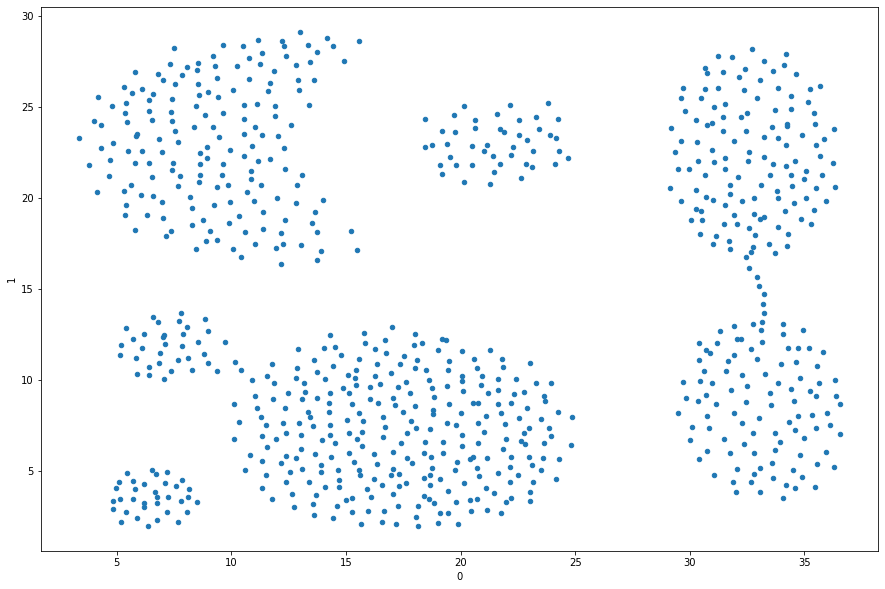

In [5]:
data = pd.read_csv('../data/data.csv', header=None)
print('Number of samples: ', len(data))
data.plot.scatter(0, 1, figsize=(15, 10))
plt.show()

data = data.values

In [7]:
mean = data.mean()
std = data.std()
data = (data - mean) / std

In [8]:
class DBSCAN:
    def __init__(self, min_samples, eps):
        """
        Constructs DBSCAN given parameters of neighborhood

        :param min_samples: Minimum samples within eps radius to be consider as a core point
        :param eps: Radius of core point
        """
        self.min_samples = min_samples
        self.eps = eps

        self.labels = None  # '0': Haven't processed, '-1': noise, 'C': cluster number
        self.core_points = None

    def fit_predict(self, x, *args, **kwargs):
        """
        Fits the data using DBSCAN and returns labels and core points
        Order of data matter!

        Algorithm:
            1. Consider a list of points that have not been seen yet
            2. Read an arbitrary point until there is no unseen point left
            3. If there are at least ``min_samples`` points within a radius of ``eps``
                then all these points are from same cluster
            4. Expand this cluster for its all core points for all neighbors
            5. Repeat

        :param x: N-dimensional numpy array

        :return: A tuple of labels of each point and index of core points
            where label=-1 corresponds to noise data and label=N N>=1 demonstrates cluster label
        """

        self.labels = np.zeros((len(x),))
        self.core_points = np.zeros((len(x),))
        current_cluster = 1  # we use 1->inf

        for pnt in range(len(x)):
            # if self.labels[pnt] == -1 or self.labels[pnt] >= 1:
            if self.labels[pnt] == 0:
                neighbor_indices = self.__nearest_neighbors(x, x[pnt])

                if len(neighbor_indices) >= self.min_samples:
                    self.__expand(x, pnt, current_cluster)
                    current_cluster += 1
                else:  # noise/outlier scenario
                    self.labels[pnt] = -1
        return self.labels, self.core_points

    def __nearest_neighbors(self, data, point):
        """
        Finds points near to the point ``point`` within the range of ``eps``

        :param point: A point
        :param: All points

        :return: Indices of nearest neighbor points
        """
        distances = euclidean_distances(data, point.reshape(1, -1))
        neighbors = distances <= self.eps
        topk = np.argsort(distances, axis=0)
        neighbors_idx = np.max(neighbors[topk].nonzero()[0]) + 1
        return topk[:neighbors_idx].flatten()

    def __expand(self, data, point_idx, current_cluster):
        """
        Expands ``current_cluster`` using given point w.r.t. ``eps`` and ``min_samples``
        Algorithm:
            1. Get a point as the start point for ``current_cluster``
            2. Get its neighbors and go through them one by one using queue logic
            3. If the neighbor is noise, then add it to the current cluster, if it is unseen, get all its neighbors
                 then add them to the list of neighbors of original point
            4. Repeat step 2 and 3 until all points in the list of neighbors are processed.

        :param data: Whole data to be clustered
        :param point_idx: The index of a point of the current cluster as the start point for expansion
        :param current_cluster: The label of current cluster
        :return: None
        """

        self.labels[point_idx] = current_cluster
        neighbors_indices = deepcopy(self.__nearest_neighbors(data, data[point_idx]))

        while len(neighbors_indices) > 0:
            neighbor_point = neighbors_indices[0]
            neighbors_indices = np.delete(neighbors_indices, 0, 0)
            if self.labels[neighbor_point] == -1:
                self.labels[neighbor_point] = current_cluster
            elif self.labels[neighbor_point] == 0:
                self.labels[neighbor_point] = current_cluster
                neighbors_indices_neighbor_point = self.__nearest_neighbors(data, data[neighbor_point])
                if len(neighbors_indices_neighbor_point) >= self.min_samples:
                    neighbors_indices = np.concatenate((neighbors_indices, neighbors_indices_neighbor_point))
                    self.core_points[neighbor_point] = 1

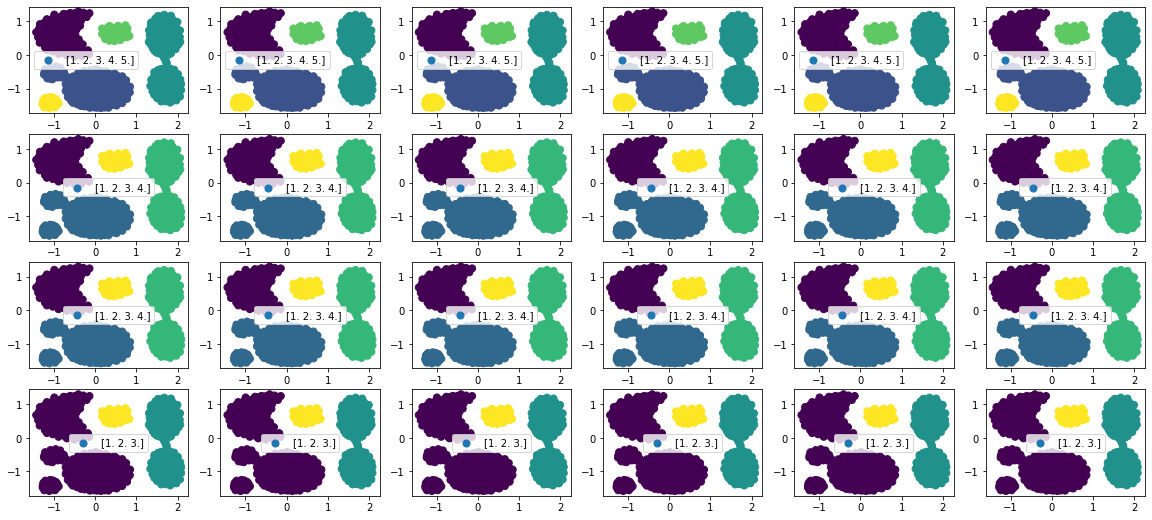

In [9]:
parameters = {'eps': [0.25, 0.3, 0.35, 0.4], 'min_samples': [3, 4, 5, 6, 7, 10]}

plt.figure(figsize=(20, 9))
i = 0
for dist in parameters['eps']:
    for min_pnt in parameters['min_samples']:
        dbscan = DBSCAN(min_samples=min_pnt, eps=dist)
        y_dbscan, _ = dbscan.fit_predict(data)
        plt.subplot(len(parameters['eps']), len(parameters['min_samples']), i+1)
        i += 1
        plt.scatter(data[:, 0], data[:, 1], c=y_dbscan, s=50, cmap='viridis', label=np.unique(y_dbscan))
        plt.legend()
plt.show()

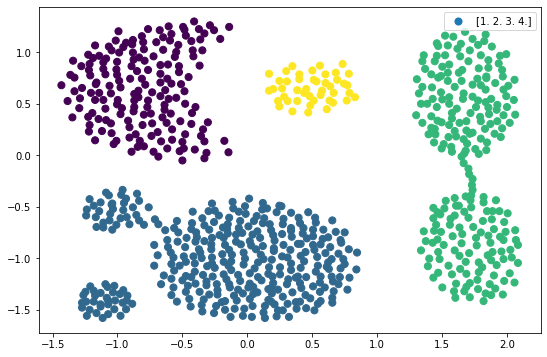

In [12]:
plt.figure(figsize=(9, 6))
dbscan = DBSCAN(min_samples=5, eps=0.3)
y_dbscan, centers = dbscan.fit_predict(data)
plt.scatter(data[:, 0], data[:, 1], c=y_dbscan, s=50, cmap='viridis', label=np.unique(y_dbscan))
plt.legend()
plt.show()

## KMeans

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Number of samples:  788


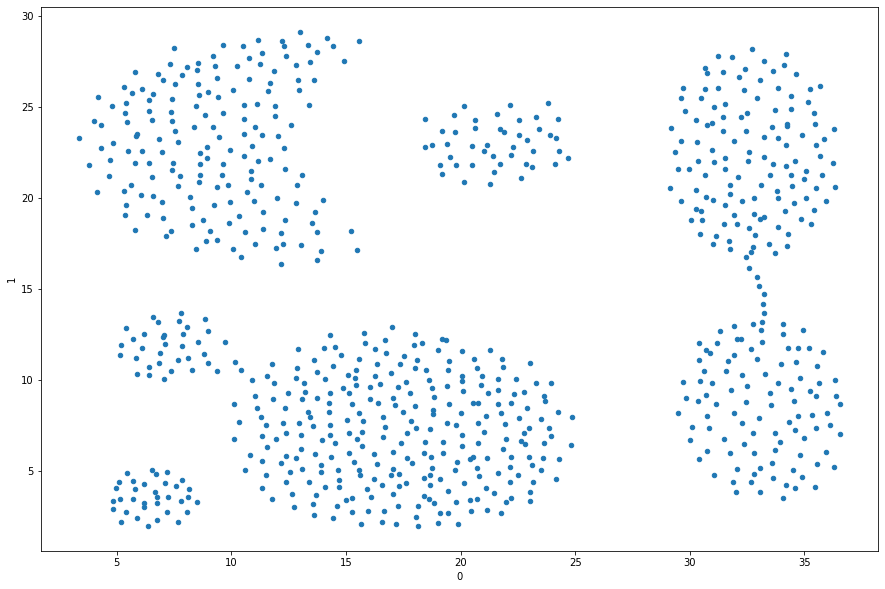

In [3]:
data = pd.read_csv('../data/data.csv', header=None)
print('Number of samples: ',len(data))
data.plot.scatter(0, 1, figsize=(15, 10))
plt.show()

data = data.values

In [4]:
# normalization
mean = data.mean()
std = data.std()
data = (data - mean) / std

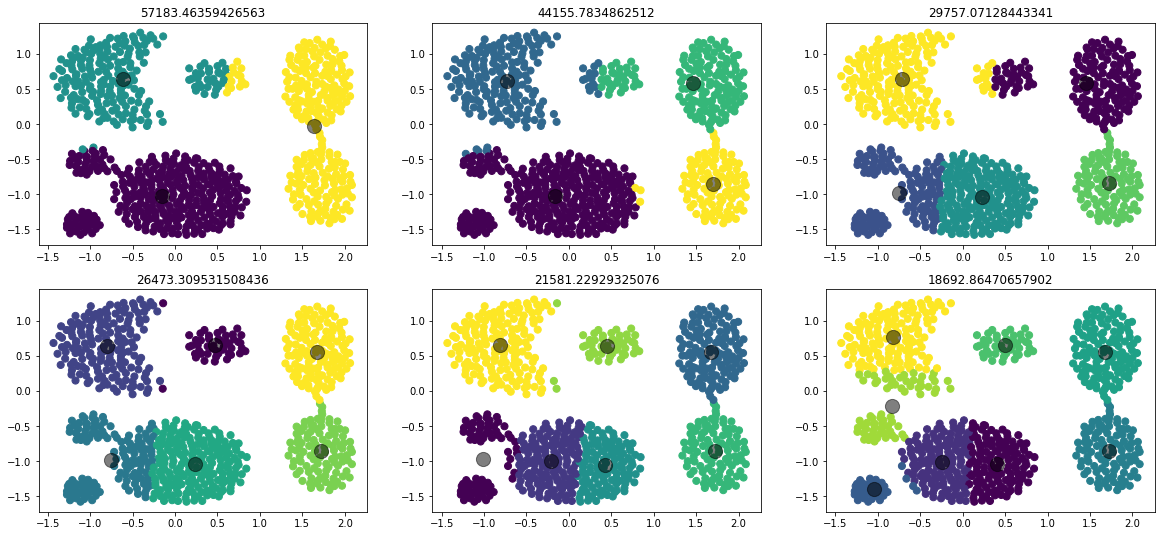

In [19]:
# DBI
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import make_scorer

from sklearn.cluster import KMeans

def DB_loss_function(estimator, X, y_true=None):
    """
    Computes Davis-Bolding Index for a fitted KMeans

    args:
        model: Fitted KMeans object
        x: input data for evaluation 
    """
    preds = estimator.predict(X)
    n_clusters = int(np.max(preds))+1

    db_values = []
    for i in range(n_clusters):
        for j in range(i+1, n_clusters):
            cluster_i = X[preds == i]
            cluster_j = X[preds == j]
            
            avg_cluster_i = 2 * np.sum(euclidean_distances(cluster_i, cluster_i)) / len(cluster_i)*(len(cluster_i)-1)
            avg_cluster_j = 2 * np.sum(euclidean_distances(cluster_j, cluster_j)) / len(cluster_j)*(len(cluster_j)-1)

            u_cluster_i = np.sum(cluster_i, axis=0) / len(cluster_i)
            u_cluster_j = np.sum(cluster_j, axis=0) / len(cluster_j)
            db = (avg_cluster_i + avg_cluster_j) / np.sum(euclidean_distances(
                u_cluster_i.reshape(-1,1), 
                u_cluster_j.reshape(-1,1)))
            db_values.append(db)
    dbi = np.sum(np.array(db_values)) / n_clusters
    return dbi

DBI_Scorer = make_scorer(DB_loss_function, greater_is_better=False)

n_clusters = np.arange(3, 9) 
plt.figure(figsize=(20, 9))

for i, n in enumerate(n_clusters):
    kmeans = KMeans(n_clusters=n, init='random')
    kmeans.fit(data)
    y_kmeans = kmeans.predict(data)

    plt.subplot(2, 3, i+1)
    plt.scatter(data[:, 0], data[:, 1], c=y_kmeans, s=50, cmap='viridis')

    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    plt.title(DB_loss_function(kmeans, data))
plt.show()

In [ ]:
# grid search model training

from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV

parameters = {'n_clusters':list(np.arange(3, 10)), 'init':['random'], 
              'algorithm':('elkan', 'full'), 'tol':[0.0001, 0.001, 0.00005, 0.00001, 0.0005], 'max_iter':[300, 1000]}

best_model = None
best_score = np.inf

for n_c in parameters['n_clusters']:
    for al in parameters['algorithm']:
        for t in parameters['tol']:
            for i in parameters['max_iter']:
                kmeans = KMeans(**{'n_clusters':n_c, 'algorithm':al, 'tol': t, 'init': 'random', 'max_iter': i})
                kmeans.fit(data)
                dbi = DB_loss_function(kmeans, data)
                if dbi < best_score:
                    print('model config: ', str(kmeans), '\n', 'dbi score:', dbi)
                    best_score = dbi
                    best_model = kmeans
best_model

model config:  KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0) 
 dbi score: 57183.46359426563
model config:  KMeans(algorithm='full', copy_x=True, init='random', max_iter=300, n_clusters=3,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=None,
       tol=0.0001, verbose=0) 
 dbi score: 57081.73694047507
model config:  KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0) 
 dbi score: 44155.783486251195
model config:  KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=5e-05, verbose=0) 
 dbi score: 43970.91716060179
model config:  KMeans(algorithm='elkan', copy_x=True,

KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0005, verbose=0)

In [ ]:
best_model

KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0005, verbose=0)

13690.561580760907

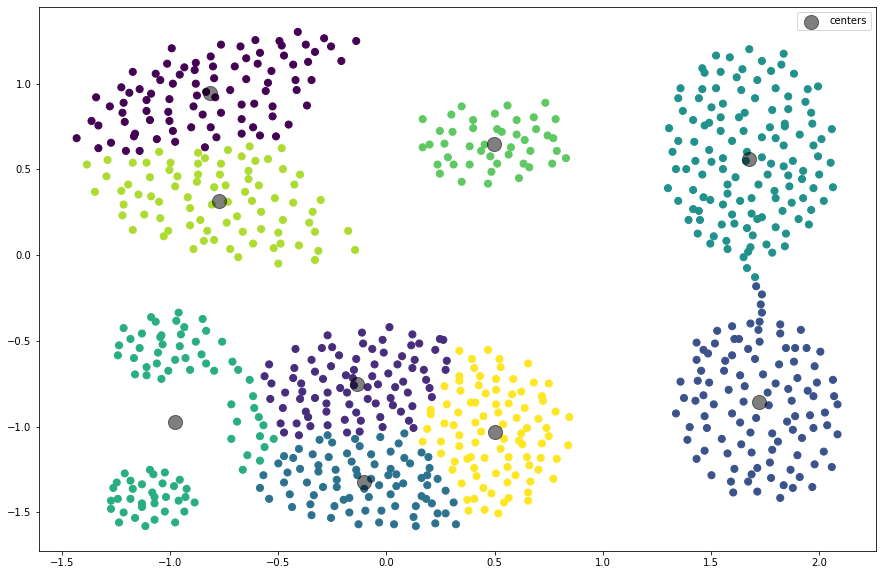

In [ ]:
y_kmeans = best_model.predict(data)

plt.figure(figsize=(15, 10))
plt.scatter(data[:, 0], data[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = best_model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5, label='centers')
plt.legend()

DB_loss_function(best_model, data)